# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, increase K from 4 to 8.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-26 19:34:38.757715


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=8
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = [1]   # exclude H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: [1]


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 19:35:11.191120
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4993, 4)           262148    
                                                                 
 conv1d (Conv1D)             (None, 4986, 64)          2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1245, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1245, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1238, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 19:35:11.566799
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 19:35:23.161643

Training # 1 1
2023-03-26 19:35:23.161839
2023-03-26 19:35:23.161903
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 19:35:24.532962


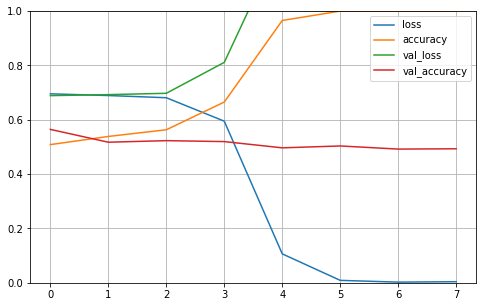


2023-03-26 19:38:48.206132

Testing # 1 1
2023-03-26 19:38:48.206242
2023-03-26 19:38:48.206305
PREDICT
2023-03-26 19:38:48.477558
Test 1:0 458:412 52.64%
Predict 1:0 473:397 54.37%
Test sizes (870, 4993) (870,)
Range of scores: 2.946468e-06 to 0.99999976
Score threshold 0.5
Confusion matrix
 [[184 228]
 [213 245]]
Normalized matrix
 [[0.21149425 0.26206897]
 [0.24482759 0.2816092 ]]


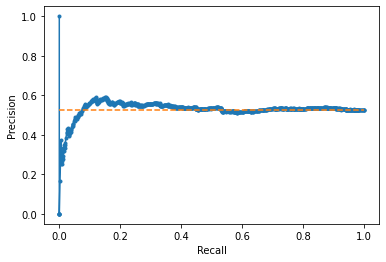

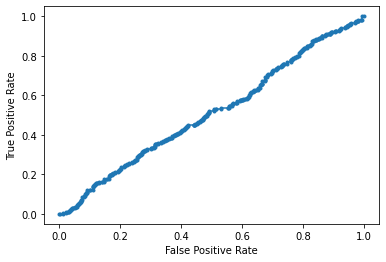

Accuracy: 49.31% Precision: 51.80% Recall: 53.49%
F1: 52.63% MCC: -0.0185
AUPRC: 52.96% AUROC: 51.26%
 accuracy [49.310344827586206]
 precision [51.79704016913319]
 recall [53.493449781659386]
 F1 [52.63157894736842]
 MCC [-0.018508489442912897]
 AUPRC [52.9589884569869]
 AUROC [51.26234790350617]
2023-03-26 19:38:49.794724

Training # 1 2
2023-03-26 19:38:49.798913
2023-03-26 19:38:49.799294
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 19:38:52.365737


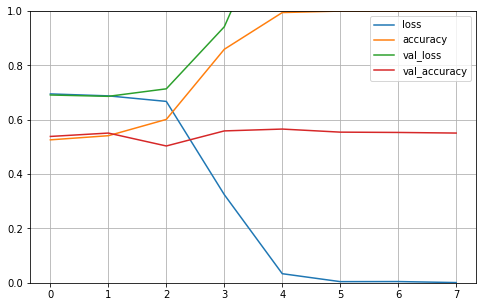


2023-03-26 19:41:17.204526

Testing # 1 2
2023-03-26 19:41:17.204907
2023-03-26 19:41:17.204954
PREDICT
2023-03-26 19:41:17.483393
Test 1:0 442:442 50.00%
Predict 1:0 479:405 54.19%
Test sizes (884, 4993) (884,)
Range of scores: 1.5447885e-07 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[225 217]
 [180 262]]
Normalized matrix
 [[0.25452489 0.24547511]
 [0.20361991 0.29638009]]


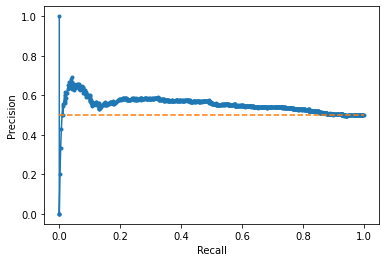

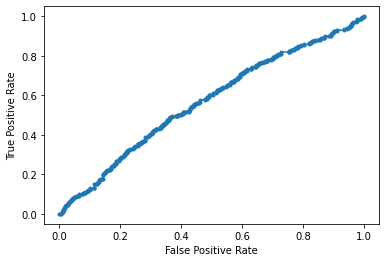

Accuracy: 55.09% Precision: 54.70% Recall: 59.28%
F1: 56.89% MCC: 0.1022
AUPRC: 55.32% AUROC: 56.90%
 accuracy [55.09049773755657]
 precision [54.69728601252609]
 recall [59.276018099547514]
 F1 [56.89467969598263]
 MCC [0.10216855368051904]
 AUPRC [55.31670536048957]
 AUROC [56.895589770889224]
2023-03-26 19:41:18.682752

Training # 1 3
2023-03-26 19:41:18.687295
2023-03-26 19:41:18.687798
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 19:41:21.198224


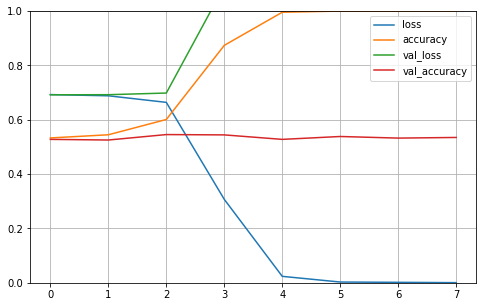


2023-03-26 19:43:44.962485

Testing # 1 3
2023-03-26 19:43:44.962595
2023-03-26 19:43:44.962648
PREDICT
2023-03-26 19:43:45.222543
Test 1:0 442:407 52.06%
Predict 1:0 467:382 55.01%
Test sizes (849, 4993) (849,)
Range of scores: 2.4544218e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[197 210]
 [185 257]]
Normalized matrix
 [[0.23203769 0.24734982]
 [0.21790342 0.30270907]]


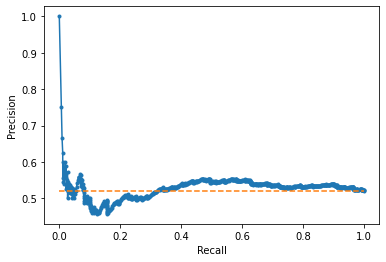

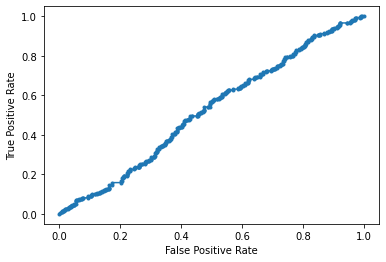

Accuracy: 53.47% Precision: 55.03% Recall: 58.14%
F1: 56.55% MCC: 0.0658
AUPRC: 52.98% AUROC: 52.32%
 accuracy [53.47467608951708]
 precision [55.0321199143469]
 recall [58.144796380090504]
 F1 [56.54565456545655]
 MCC [0.06575215038793861]
 AUPRC [52.98104847019525]
 AUROC [52.31942143706849]
2023-03-26 19:43:46.807297

Training # 1 4
2023-03-26 19:43:46.807473
2023-03-26 19:43:46.807520
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 19:43:49.425653


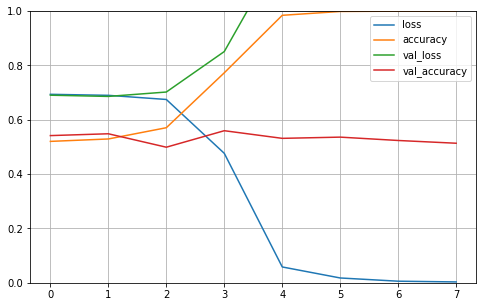


2023-03-26 19:46:06.261951

Testing # 1 4
2023-03-26 19:46:06.262049
2023-03-26 19:46:06.262085
PREDICT
2023-03-26 19:46:06.526594
Test 1:0 459:431 51.57%
Predict 1:0 460:430 51.69%
Test sizes (890, 4993) (890,)
Range of scores: 1.525205e-07 to 0.99999464
Score threshold 0.5
Confusion matrix
 [[214 217]
 [216 243]]
Normalized matrix
 [[0.24044944 0.24382022]
 [0.24269663 0.27303371]]


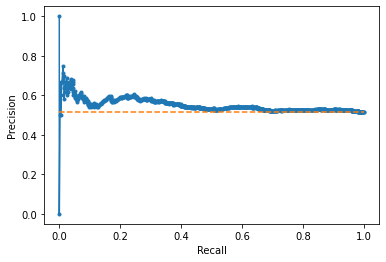

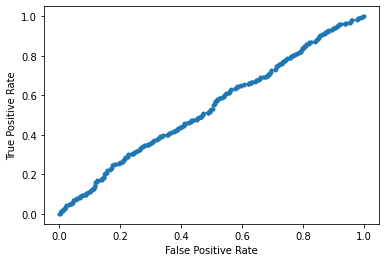

Accuracy: 51.35% Precision: 52.83% Recall: 52.94%
F1: 52.88% MCC: 0.0259
AUPRC: 55.07% AUROC: 53.87%
 accuracy [51.348314606741575]
 precision [52.826086956521735]
 recall [52.94117647058824]
 F1 [52.8835690968444]
 MCC [0.025933387157068048]
 AUPRC [55.06845302648545]
 AUROC [53.865712307093496]
2023-03-26 19:46:07.702324

Training # 1 5
2023-03-26 19:46:07.702515
2023-03-26 19:46:07.702567
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 19:46:09.085131


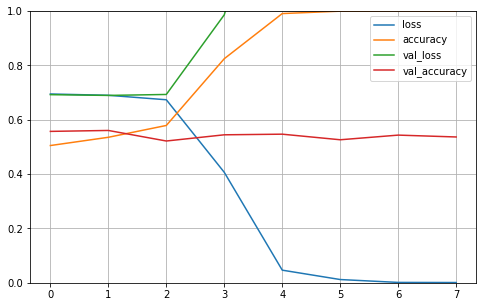


2023-03-26 19:48:32.449795

Testing # 1 5
2023-03-26 19:48:32.452887
2023-03-26 19:48:32.453220
PREDICT
2023-03-26 19:48:32.959040
Test 1:0 457:419 52.17%
Predict 1:0 527:349 60.16%
Test sizes (876, 4993) (876,)
Range of scores: 1.0349996e-07 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[181 238]
 [168 289]]
Normalized matrix
 [[0.206621   0.2716895 ]
 [0.19178082 0.32990868]]


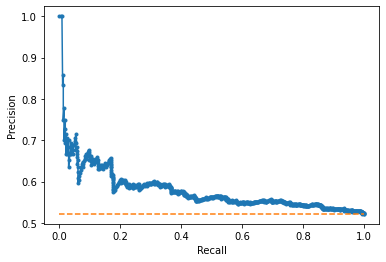

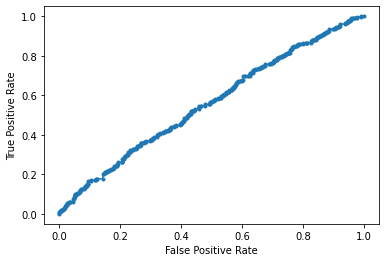

Accuracy: 53.65% Precision: 54.84% Recall: 63.24%
F1: 58.74% MCC: 0.0657
AUPRC: 58.04% AUROC: 55.94%
 accuracy [53.65296803652968]
 precision [54.83870967741935]
 recall [63.23851203501094]
 F1 [58.73983739837397]
 MCC [0.06567556162488009]
 AUPRC [58.03841695961971]
 AUROC [55.939952893990586]
2023-03-26 19:48:34.287579

Training # 2 1
2023-03-26 19:48:34.289763
2023-03-26 19:48:34.289862
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 19:48:35.706287


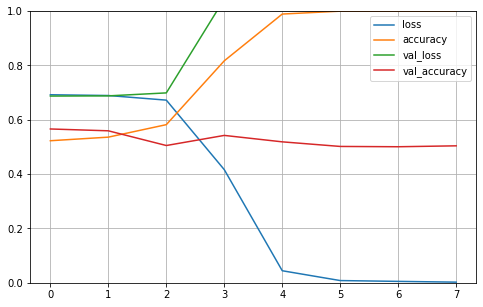


2023-03-26 19:50:59.043986

Testing # 2 1
2023-03-26 19:50:59.045497
2023-03-26 19:50:59.045872
PREDICT
2023-03-26 19:50:59.550207
Test 1:0 472:415 53.21%
Predict 1:0 490:397 55.24%
Test sizes (887, 4993) (887,)
Range of scores: 4.5297618e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[186 229]
 [211 261]]
Normalized matrix
 [[0.2096956  0.25817362]
 [0.2378805  0.29425028]]


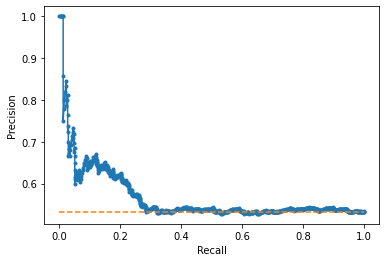

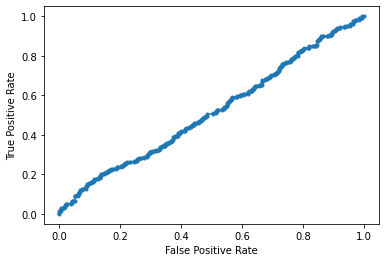

Accuracy: 50.39% Precision: 53.27% Recall: 55.30%
F1: 54.26% MCC: 0.0012
AUPRC: 56.80% AUROC: 51.76%
 accuracy [50.3945885005637]
 precision [53.265306122448976]
 recall [55.29661016949152]
 F1 [54.26195426195426]
 MCC [0.0011628870015748802]
 AUPRC [56.80435574935232]
 AUROC [51.76026138452114]
2023-03-26 19:51:00.928518

Training # 2 2
2023-03-26 19:51:00.928721
2023-03-26 19:51:00.928774
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 19:51:02.284307


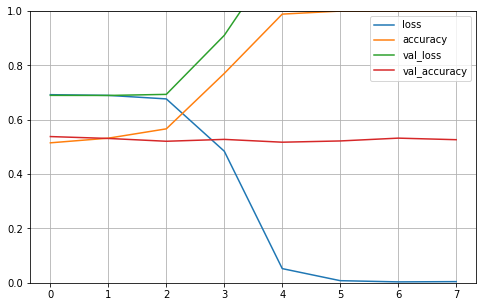


2023-03-26 19:53:11.246249

Testing # 2 2
2023-03-26 19:53:11.246348
2023-03-26 19:53:11.246386
PREDICT
2023-03-26 19:53:11.502852
Test 1:0 452:416 52.07%
Predict 1:0 493:375 56.80%
Test sizes (868, 4993) (868,)
Range of scores: 1.6577033e-05 to 0.99999976
Score threshold 0.5
Confusion matrix
 [[190 226]
 [185 267]]
Normalized matrix
 [[0.21889401 0.26036866]
 [0.21313364 0.30760369]]


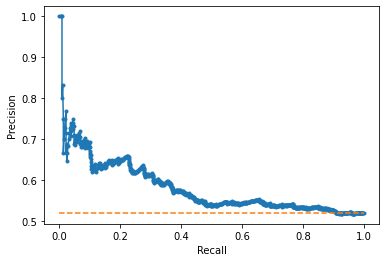

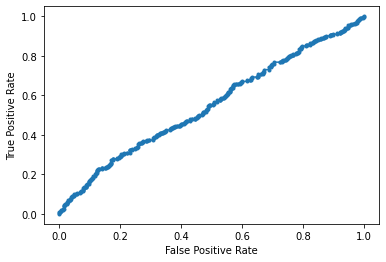

Accuracy: 52.65% Precision: 54.16% Recall: 59.07%
F1: 56.51% MCC: 0.0478
AUPRC: 58.23% AUROC: 55.04%
 accuracy [52.64976958525346]
 precision [54.15821501014199]
 recall [59.070796460176986]
 F1 [56.507936507936506]
 MCC [0.047842060745710034]
 AUPRC [58.2347992013866]
 AUROC [55.03983364533697]
2023-03-26 19:53:13.543200

Training # 2 3
2023-03-26 19:53:13.543428
2023-03-26 19:53:13.543485
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 19:53:15.569257


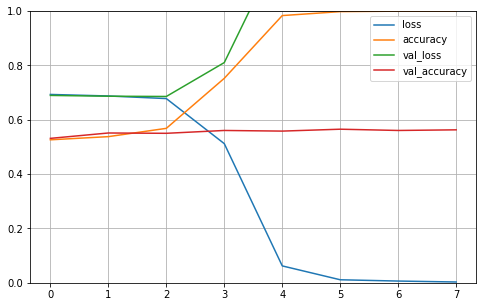


2023-03-26 19:55:38.897399

Testing # 2 3
2023-03-26 19:55:38.899289
2023-03-26 19:55:38.899618
PREDICT
2023-03-26 19:55:39.397727
Test 1:0 453:407 52.67%
Predict 1:0 517:343 60.12%
Test sizes (860, 4993) (860,)
Range of scores: 3.8751313e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[187 220]
 [156 297]]
Normalized matrix
 [[0.21744186 0.25581395]
 [0.18139535 0.34534884]]


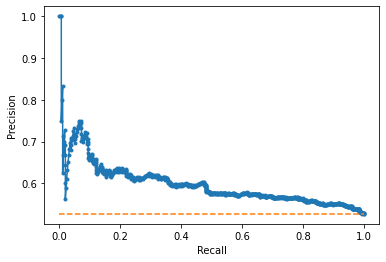

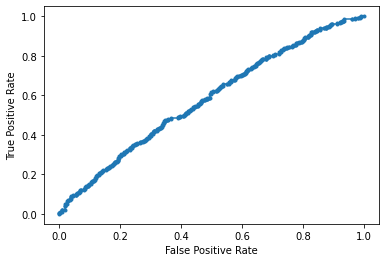

Accuracy: 56.28% Precision: 57.45% Recall: 65.56%
F1: 61.24% MCC: 0.1174
AUPRC: 59.84% AUROC: 58.22%
 accuracy [56.27906976744186]
 precision [57.446808510638306]
 recall [65.56291390728477]
 F1 [61.23711340206186]
 MCC [0.1173508597197174]
 AUPRC [59.839692605242604]
 AUROC [58.222280076584724]
2023-03-26 19:55:42.007890

Training # 2 4
2023-03-26 19:55:42.008059
2023-03-26 19:55:42.008105
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 19:55:43.375167


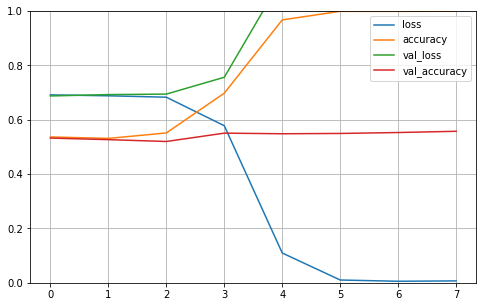


2023-03-26 19:57:45.218016

Testing # 2 4
2023-03-26 19:57:45.218465
2023-03-26 19:57:45.218507
PREDICT
2023-03-26 19:57:45.503763
Test 1:0 432:447 49.15%
Predict 1:0 505:374 57.45%
Test sizes (879, 4993) (879,)
Range of scores: 9.750425e-06 to 1.0
Score threshold 0.5
Confusion matrix
 [[216 231]
 [158 274]]
Normalized matrix
 [[0.24573379 0.26279863]
 [0.17974972 0.31171786]]


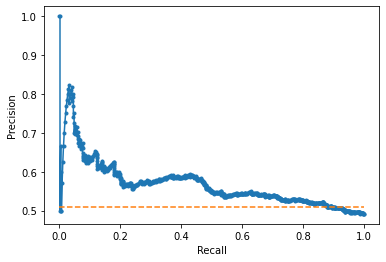

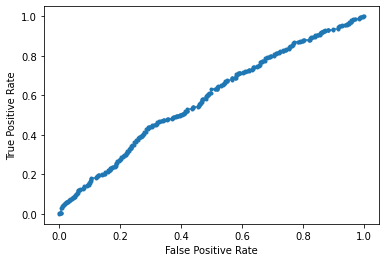

Accuracy: 55.75% Precision: 54.26% Recall: 63.43%
F1: 58.48% MCC: 0.1188
AUPRC: 56.77% AUROC: 58.32%
 accuracy [55.745164960182024]
 precision [54.25742574257426]
 recall [63.42592592592593]
 F1 [58.484525080042694]
 MCC [0.11879025171935231]
 AUPRC [56.765941236455355]
 AUROC [58.31831551909852]
2023-03-26 19:57:46.670536

Training # 2 5
2023-03-26 19:57:46.672496
2023-03-26 19:57:46.672566
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 19:57:48.061335


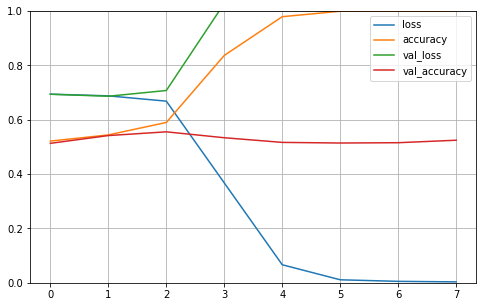


2023-03-26 20:00:11.304085

Testing # 2 5
2023-03-26 20:00:11.304200
2023-03-26 20:00:11.304238
PREDICT
2023-03-26 20:00:11.555596
Test 1:0 449:426 51.31%
Predict 1:0 479:396 54.74%
Test sizes (875, 4993) (875,)
Range of scores: 7.922518e-09 to 0.99999964
Score threshold 0.5
Confusion matrix
 [[203 223]
 [193 256]]
Normalized matrix
 [[0.232      0.25485714]
 [0.22057143 0.29257143]]


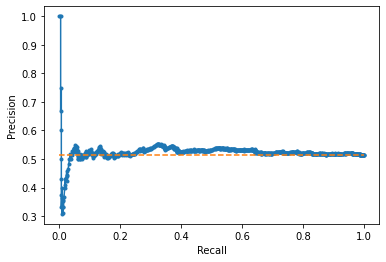

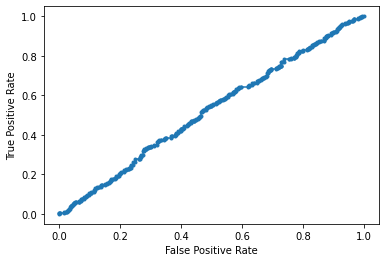

Accuracy: 52.46% Precision: 53.44% Recall: 57.02%
F1: 55.17% MCC: 0.0469
AUPRC: 52.47% AUROC: 52.20%
 accuracy [52.457142857142856]
 precision [53.444676409185796]
 recall [57.01559020044543]
 F1 [55.172413793103445]
 MCC [0.04687696686330722]
 AUPRC [52.467173590763316]
 AUROC [52.19841693068582]
2023-03-26 20:00:12.246902


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 53.04% std 2.28
 precision mean 54.18% std 1.53
 recall mean 58.75% std 4.29
 F1 mean 56.34% std 2.71
 MCC mean 0.06% std 0.05
 AUPRC mean 55.85% std 2.52
 AUROC mean 54.58% std 2.69
 accuracy [[49.310344827586206], [55.09049773755657], [53.47467608951708], [51.348314606741575], [53.65296803652968], [50.3945885005637], [52.64976958525346], [56.27906976744186], [55.745164960182024], [52.457142857142856]]
 precision [[51.79704016913319], [54.69728601252609], [55.0321199143469], [52.826086956521735], [54.83870967741935], [53.265306122448976], [54.15821501014199], [57.446808510638306], [54.25742574257426], [53.444676409185796]]
 recall [[53.493449781659386], [59.276018099547514], [58.144796380090504], [52.94117647058824], [63.23851203501094], [55.29661016949152], [59.070796460176986], [65.56291390728477], [63.42592592592593], [57.01559020044543]]
 F1 [[52.63157894736842], [56.89467969598263], [56.54565456545655], [52.8835690968444], [58.73983739837397], [54.26195426195426], 